<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%203/1_GAN_1_Really_Simple_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simplificación de 

https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87


In [1]:
import os
import numpy as np

from IPython.core.debugger import Tracer

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg') # allows code to run without a system DISPLAY



In [2]:
# Datos
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)


11493376/11490434 [==============================] - 0s 0us/step


In [3]:
width=28
height=28
channels=1

in_shape = X_train.shape
in_shape = in_shape[1:]
OPTIMZADOR_ADAM = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

In [4]:
# Generador

model_gen = Sequential()
model_gen.add(Dense(256, input_shape=(100,)))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(512))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(1024))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(np.prod(in_shape), activation='tanh')) #a veces tanh funciona mejor que sigmoid como activación de la última capa.
model_gen.add(Reshape(in_shape))
model_gen.summary()
model_gen.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

## Otra de las diferencias entre TANH y SIGMOID es:
## TANH: salida entre -1 y +1
## SIGMOID: salida entre 0 y 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

In [5]:
# Discriminador

model_Disc = Sequential()
model_Disc.add(Flatten(input_shape=in_shape))
model_Disc.add(Dense(128, input_shape=in_shape))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(64))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(1, activation='sigmoid'))
model_Disc.summary()
model_Disc.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
________________________________________________

In [6]:
# modelo combinado

model_gan = Sequential()
model_gan.add(model_gen)
model_gan.add(model_Disc)
model_gan.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

model_gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         1493520   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 108801    
Total params: 1,602,321
Trainable params: 1,598,737
Non-trainable params: 3,584
_________________________________________________________________


In [24]:
ratio = 1

epochs = 1000
batch = 10

# Entrenamiento

DD_loss = np.zeros((epochs,))
GG_loss = np.zeros((epochs,))

for cnt in range(epochs):

    ## train discriminator
    batch_discr = np.round(ratio*batch)
    random_index = np.random.randint(0, len(X_train) - np.int64(batch_discr))
    legit_images = X_train[random_index : random_index + np.int64(batch_discr)].reshape((np.int64(batch_discr),)+in_shape)

    gen_noise = np.random.normal(0, 1, (np.int64(batch_discr), 100))
    syntetic_images = model_gen.predict(gen_noise)

    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    y_combined_batch = np.concatenate((np.ones((np.int64(batch_discr), 1)), np.zeros((np.int64(batch_discr), 1))))

    d_loss = model_Disc.train_on_batch(x_combined_batch, y_combined_batch)


    # train generator
    batch_gen = np.int64(np.round(batch/ratio))

    noise = np.random.normal(0, 1, (2*batch_gen, 100))
    y_mislabled = np.ones((2*batch_gen, 1))

    g_loss = model_gan.train_on_batch(noise, y_mislabled)

    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f], [ batch discr :: loss: %f], , [ bacth gen :: loss: %f]' % (cnt, d_loss[0], g_loss, batch_discr, batch_gen))

    DD_loss[cnt] = d_loss[0]
    GG_loss[cnt] = g_loss

    ratio = DD_loss[cnt]/GG_loss[cnt]
    
    
    

epoch: 0, [Discriminator :: d_loss: 0.810110], [ Generator :: loss: 0.356665], [ batch discr :: loss: 10.000000], , [ bacth gen :: loss: 10.000000]
epoch: 1, [Discriminator :: d_loss: 0.780789], [ Generator :: loss: 0.357892], [ batch discr :: loss: 23.000000], , [ bacth gen :: loss: 4.000000]
epoch: 2, [Discriminator :: d_loss: 0.771558], [ Generator :: loss: 0.351551], [ batch discr :: loss: 22.000000], , [ bacth gen :: loss: 5.000000]
epoch: 3, [Discriminator :: d_loss: 0.794742], [ Generator :: loss: 0.330610], [ batch discr :: loss: 22.000000], , [ bacth gen :: loss: 5.000000]
epoch: 4, [Discriminator :: d_loss: 0.790106], [ Generator :: loss: 0.330241], [ batch discr :: loss: 24.000000], , [ bacth gen :: loss: 4.000000]
epoch: 5, [Discriminator :: d_loss: 0.821301], [ Generator :: loss: 0.319082], [ batch discr :: loss: 24.000000], , [ bacth gen :: loss: 4.000000]
epoch: 6, [Discriminator :: d_loss: 0.806686], [ Generator :: loss: 0.313521], [ batch discr :: loss: 26.000000], , [

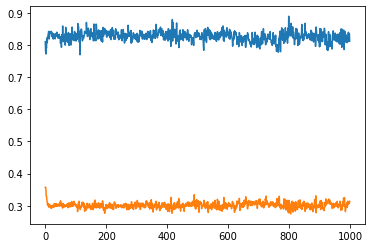

In [25]:
% matplotlib inline 
plt.figure
plt.plot(DD_loss)
plt.plot(GG_loss)

# Generar datos

In [9]:
gen_noise = np.random.normal(0, 1, (np.int64(10), 100))
syntetic_images = model_gen.predict(gen_noise)

In [19]:
syntetic_images.shape

(5, 28, 28, 1)

(-0.5, 27.5, 27.5, -0.5)

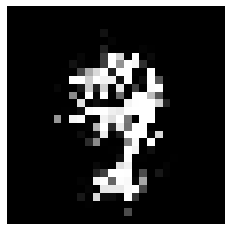

In [20]:
plt.imshow(syntetic_images[0,:,:,0],cmap='gray')
plt.axis('off')